In [1]:
files = {'nt_muts': 'results/nt_muts.json',
         'aa_muts': 'results/aa_muts.json',
         'tree': 'results/tree.nwk',
         'couplings': 'results/annotated_ranked_couplings.tsv',
         'genbank': 'config/reference.gb',
         'refseq': 'config/reference_refseq.gb',
         'time': 'results/branch_lengths.json'}

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

sns.set_context('talk')

import json
import itertools
import numpy as np
import pandas as pd
from Bio import Phylo
from Bio import SeqIO
from scipy.interpolate import interp1d

s = SeqIO.read(files['genbank'], 'genbank')
r = SeqIO.read(files['refseq'], 'genbank')

t = Phylo.read(files['tree'], 'newick')
ngenomes = len({x.name for x in t.get_terminals() + t.get_nonterminals()
                if 'NODE_' not in x.name})

nt = json.load(open(files['nt_muts']))

nt_muts = {k: {x: 1 for x in nt['nodes'][k]['muts']}
           for k in nt['nodes']
           if not k.startswith('NODE_')}
ntn_muts = {k: {int(x[1:-1]): 1 for x in nt['nodes'][k]['muts']}
           for k in nt['nodes']
           if not k.startswith('NODE_')}

for c in t.get_nonterminals():
    if c.name not in nt['nodes']:
        continue
    for m in nt['nodes'][c.name]['muts']:
        for n in c.get_terminals():
            nt_muts[n.name][m] = 1
            ntn_muts[n.name][int(m[1:-1])] = 1

nt = {x for k in nt_muts for x in nt_muts[k]}
ntn = {int(x[1:-1]) for x in nt}

aa = json.load(open(files['aa_muts']))

aa_muts = {}
for sample in aa['nodes']:
    if sample.startswith('NODE_'):
        continue
    aa_muts[sample] = {}
    for gene, muts in aa['nodes'][sample]['aa_muts'].items():
        if len(muts) > 0:
            aa_muts[sample][gene] = set()
        for mut in muts:
            aa_muts[sample][gene].add(mut)

for c in t.get_nonterminals():
    if c.name not in aa['nodes']:
        continue
    for g, ms in aa['nodes'][c.name]['aa_muts'].items():
        for n in c.get_terminals():
            aa_muts[n.name][g] = aa_muts[n.name].get(g, set())
            for m in ms: 
                aa_muts[n.name][g].add(m)

aa = {'%s-%s' % (g, pos)
      for k in aa_muts
      for g in aa_muts[k]
      for pos in aa_muts[k][g]}

ntdf = pd.DataFrame(nt_muts)
ntdf[np.isnan(ntdf)] = 0
ntf = ntdf.T.sum() / ntdf.shape[1]
ntndf = pd.DataFrame(ntn_muts)
ntndf[np.isnan(ntndf)] = 0
ntnf = ntndf.T.sum() / ntndf.shape[1]
npos = set(ntf[ntf > 0.01].index)
pos = {int(x[1:-1]) for x in set(ntf[ntf > 0.01].index)}
npositions = len(npos)
all_pos = {int(x[1:-1]) for x in set(ntf.index)}
napositions = len(all_pos)

m = pd.read_csv(files['couplings'],
                sep='\t')
m = m[(m['pos1'].isin(pos)) &
      (m['pos2'].isin(pos)) &
      (m['direct'] == 1)]
m = m.sort_values('coupling_strength')

cpos = set(m[['pos1', 'pos2']].values.flatten()).intersection(ntnf[ntnf >= 0.01].index)
nsites = len(cpos)
ccpos = set(m[m['both_coding']][['pos1', 'pos2']].values.flatten()).intersection(ntnf[ntnf >= 0.01].index)
ncsites = len(ccpos)

bl = json.load(open(files['time']))
tl = {k: bl['nodes'][k]['numdate']
      for k in bl['nodes']
      if not k.startswith('NODE_')}
tl = pd.Series(tl)

ntt = None
trange = np.arange(tl.min(), tl.max(), 1 / 365)
for t1 in trange:
    if t1 + 20 / 365 > tl.max():
        continue
    samples = ntndf.columns.intersection(set(tl[(tl >= t1) & (tl < t1 + 20 / 365)].index))
    tmp = ntndf.loc[:, samples].T.sum() / len(samples)
    tmp.name = t1 + 20/365
    if ntt is None:
        ntt = tmp.to_frame()
    else:
        ntt = ntt.join(tmp.to_frame(), how='outer')
ntt = ntt.stack().reset_index()
ntt.columns = ['pos', 'time', 'af']

tal = {k: bl['nodes'][k]['numdate']
       for k in bl['nodes']}
tacl = {k: bl['nodes'][k]['num_date_confidence']
        for k in bl['nodes']}

nt = json.load(open(files['nt_muts']))

nt_time = {}
nt_conf = {}
for k in nt['nodes']:
    time = tal[k]
    time_c = tacl[k]
    for x in nt['nodes'][k]['muts']:
        curr_time = nt_time.get(int(x[1:-1]), np.nan)
        if not np.isnan(curr_time) and curr_time < time:
            continue
        nt_time[int(x[1:-1])] = time
        nt_conf[int(x[1:-1])] = time_c

nt_time = pd.Series(nt_time)
nt_time.name = 'time'

nt_time = nt_time.to_frame().join(ntnf.to_frame(), how='outer')
nt_time.columns = ['time', 'vf']
nt_time.index.name = 'position'
nt_time['Position'] = [x if x in cpos
                       else 'Other'
                       for x in nt_time.index]
nt_time['tstart'] = [nt_conf[x][0]
                     for x in nt_time.index]
nt_time['tend'] = [nt_conf[x][1]
                     for x in nt_time.index]

No signs of co-evolution between sites in the SARS-COV-2 genomes sequenced to date, using Direct Coupling Analysis (DCA)
=====

Marco Galardini and Ahmad S. Khalil

*Biological Design Center, Boston University*

In [2]:
from IPython.display import Markdown as md

import datetime
today = datetime.datetime.today().strftime('%Y-%m-%d')

md(f"**Last update:** {today}")

**Last update:** 2020-04-07

<h5>To view the code used to generate the plots <b><a href="javascript:toggle()" target="_self">click here</a></b></h5>

In [3]:
md(f'''Introduction
---

The current COVID-19 pandemic is accelerating the advent of genomic epidemiology,
with tens of genomes of the SARS-Cov-2 virus made available every day.
This allows a near real-time interpretation of viral genetic data, aimed at understanding
the evolutionary origin of the virus, transmission chains, diagnostic strategies,
and targets for pharmacological interventions.
Among evolutionary approaches, the study of co-evolution can highlight
sites in the genome that interact directly or indirectly. Recent methodological advances allow
to apply Direct Coupling Analysis (DCA) across whole genomes and thousands of samples to highlight
co-evolving sites. Here we apply DCA to {ngenomes} whole SARS-Cov-2 genome sequences, and although
the method indicates that {nsites} are strongly coupled, we argue that this is likely due
to these sites mutating early in the pandemic and thus having a high frequency in the population.
Moreover, we observe no sign of convergence
(*i.e.* strongly coupled sites co-mutating in multiple clades) which further reinforces
our conclusion that thus far no co-evolving sites can be used to infer direct and indirect
interactions betweeen variant sites.''')

Introduction
---

The current COVID-19 pandemic is accelerating the advent of genomic epidemiology,
with tens of genomes of the SARS-Cov-2 virus made available every day.
This allows a near real-time interpretation of viral genetic data, aimed at understanding
the evolutionary origin of the virus, transmission chains, diagnostic strategies,
and targets for pharmacological interventions.
Among evolutionary approaches, the study of co-evolution can highlight
sites in the genome that interact directly or indirectly. Recent methodological advances allow
to apply Direct Coupling Analysis (DCA) across whole genomes and thousands of samples to highlight
co-evolving sites. Here we apply DCA to 4189 whole SARS-Cov-2 genome sequences, and although
the method indicates that 22 are strongly coupled, we argue that this is likely due
to these sites mutating early in the pandemic and thus having a high frequency in the population.
Moreover, we observe no sign of convergence
(*i.e.* strongly coupled sites co-mutating in multiple clades) which further reinforces
our conclusion that thus far no co-evolving sites can be used to infer direct and indirect
interactions betweeen variant sites.

In [4]:
md(f'''Results
---

Using the ncov [nextstrain](https://academic.oup.com/bioinformatics/article/34/23/4121/5001388) [pipeline](https://github.com/nextstrain/ncov)
we have generated a whole genome alignment of {ngenomes} samples, obtained
from the GISAID database on {today} (see the **acknowledgments** section for
information about the labs who kindly submitted sequences). Based on this
alignment we observe {npositions} sites with variant frequency above 1% (**Figure 1**).''')

Results
---

Using the ncov [nextstrain](https://academic.oup.com/bioinformatics/article/34/23/4121/5001388) [pipeline](https://github.com/nextstrain/ncov)
we have generated a whole genome alignment of 4189 samples, obtained
from the GISAID database on 2020-04-07 (see the **acknowledgments** section for
information about the labs who kindly submitted sequences). Based on this
alignment we observe 47 sites with variant frequency above 1% (**Figure 1**).

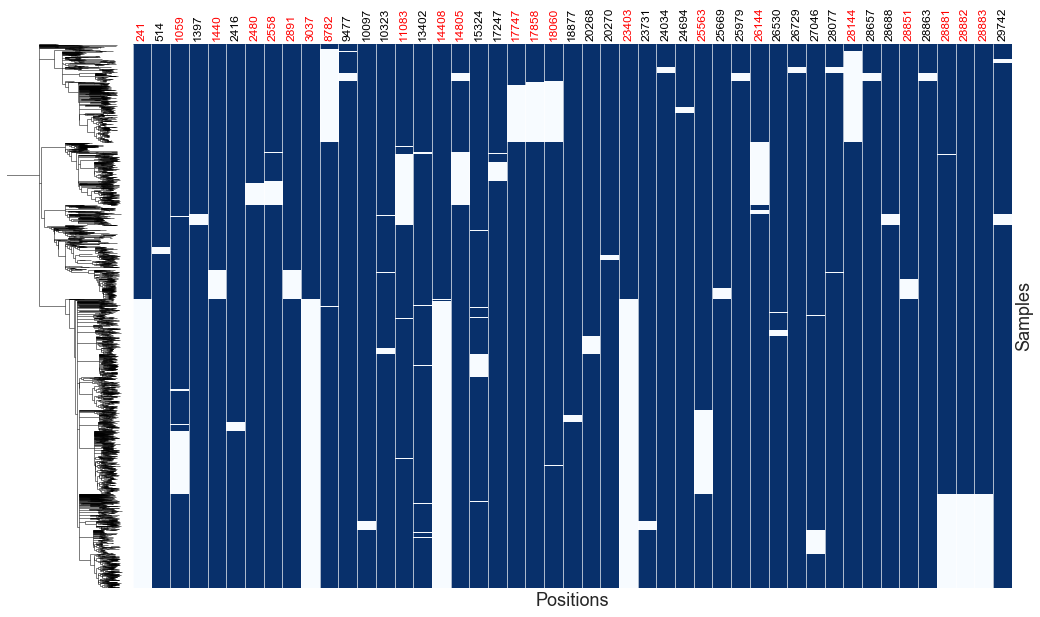

In [5]:
ntmat = ntndf.loc[ntndf.index.intersection(pos)].sort_index()

# Sort the matrix according to tip labels in the tree
nt_sorted = ntmat[[x.name for x in t.get_terminals()]]

# Plot presence/absence matrix against the tree
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(18, 10))

    ax1=plt.subplot2grid((1,40), (0, 5), colspan=35)
    a=ax1.matshow(nt_sorted.T, cmap=plt.cm.Blues_r,
               vmin=0, vmax=1,
               aspect='auto',
               interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_xticks([i for i, x in enumerate(nt_sorted.index)])
    ax1.set_xticklabels([str(x) for x in nt_sorted.index],
                        rotation=90,
                        fontdict={'color': 'k'})
    for tick in ax1.get_xticklabels():
        if int(tick.get_text()) in cpos:
            tick.set_color('r')
    ax1.tick_params(grid_linewidth=0, labelsize=12, direction='out', length=0)
    ax1.set_xlabel('Positions')
    ax1.set_ylabel('Samples')
    ax1.yaxis.set_label_position('right')
    for i, x in enumerate(nt_sorted.index):
        ax1.axvline(i - 0.5, color='white', linewidth=0.66)
    sns.despine(ax=ax1, left=True, bottom=True)

    ax = fig.add_subplot(1,2,1)
    # matplotlib v1/2 workaround
    try:
        ax=plt.subplot2grid((1,40), (0, 0), colspan=5, facecolor='white')
    except AttributeError:
        ax=plt.subplot2grid((1,40), (0, 0), colspan=5, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    with plt.rc_context({'lines.linewidth': 0.5}):
        Phylo.draw(t, axes=ax, 
                   show_confidence=False,
                   label_func=lambda x: None,
                   xticks=([],), yticks=([],),
                   ylabel=('',), xlabel=('',),
                   xlim=(0.0009,0.0013),
                   axis=('off',),
                   do_show=False,
                  )

In [6]:
md(f'''_**Figure 1.** SARS-Cov-2 time-corrected phylogenetic tree and variant sites presence/absence matrix.
In the matrix each row represent a viral genome and each column a position in the genome with at least 1%
of variant sites across all samples. White represents the presence of a variant with respect to the
reference genome (GenBank: [MN908947](https://www.ncbi.nlm.nih.gov/nuccore/MN908947)), blue absence of variants.
Columns are ordered based on their position, from left to right. The {nsites} coupled positions are highlighted in red._''')

_**Figure 1.** SARS-Cov-2 time-corrected phylogenetic tree and variant sites presence/absence matrix.
In the matrix each row represent a viral genome and each column a position in the genome with at least 1%
of variant sites across all samples. White represents the presence of a variant with respect to the
reference genome (GenBank: [MN908947](https://www.ncbi.nlm.nih.gov/nuccore/MN908947)), blue absence of variants.
Columns are ordered based on their position, from left to right. The 22 coupled positions are highlighted in red._

In [7]:
md(f'''Next, we applied Direct Coupling Analysis to sites with variant frequency above 1%,
using the implementation provided by [SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093).
We found {nsites} to be strongly coupled over {npositions} used as input, meaning that according
to this method roughly half of the positions with higher frequency variants
are co-evolving (**Figure 2**). **We however argue that this result is
due to two confounding factors, which suggest that no molecular or functional conclusions can be made at this stage.**
First, as can be clearly observed in **Figure 1**, virtually all variants are exclusive to one clade,
with no signs of convergence. If coupled sites were found to be variant across multiple clades, that
would be a stronger indication of co-evolution, since the likelihood of observing two sites co-mutating
in independent lineages in absence of recombination is very small. Second, all coupled variants appeared
early in the spread of the pandemic, as estimated by the ancestral sequence reconstruction by 
maximum likelihood implemented in [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) (**Figure 3**).
This observation implies that coupled mutations might have risen to high frequency only due to chance, and not
because they confer a selective advantage alone or due to their direct/indirect interaction.
Furthermore, we observe very little change in the observed frequencies of these
variants over time (**Figure 4**) which might also be an indication that none of them
is more likely to be adaptive.
Given these results, we are not showing further analysis about the position of
these {nsites} high frequency variants in relation to the genes encoded in the virus'
genome, so that there is a reduced risk of misinterpreting these results.''')

Next, we applied Direct Coupling Analysis to sites with variant frequency above 1%,
using the implementation provided by [SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093).
We found 22 to be strongly coupled over 47 used as input, meaning that according
to this method roughly half of the positions with higher frequency variants
are co-evolving (**Figure 2**). **We however argue that this result is
due to two confounding factors, which suggest that no molecular or functional conclusions can be made at this stage.**
First, as can be clearly observed in **Figure 1**, virtually all variants are exclusive to one clade,
with no signs of convergence. If coupled sites were found to be variant across multiple clades, that
would be a stronger indication of co-evolution, since the likelihood of observing two sites co-mutating
in independent lineages in absence of recombination is very small. Second, all coupled variants appeared
early in the spread of the pandemic, as estimated by the ancestral sequence reconstruction by 
maximum likelihood implemented in [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) (**Figure 3**).
This observation implies that coupled mutations might have risen to high frequency only due to chance, and not
because they confer a selective advantage alone or due to their direct/indirect interaction.
Furthermore, we observe very little change in the observed frequencies of these
variants over time (**Figure 4**) which might also be an indication that none of them
is more likely to be adaptive.
Given these results, we are not showing further analysis about the position of
these 22 high frequency variants in relation to the genes encoded in the virus'
genome, so that there is a reduced risk of misinterpreting these results.

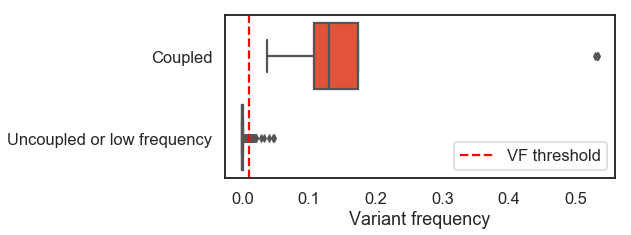

In [8]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=[ntnf.loc[cpos], ntnf.loc[ntnf.index.difference(cpos)]],
            orient='h', palette=[sns.xkcd_rgb['orange red'],
                                 sns.xkcd_rgb['light grey']])
plt.axvline(0.01, color='r', ls='dashed', label='VF threshold')
plt.yticks([0, 1], ['Coupled', 'Uncoupled or low frequency'])
plt.xlabel('Variant frequency')
plt.legend(loc='lower right',
           bbox_to_anchor=(1, 0));

In [9]:
md(f'''_**Figure 2.** Variant frequency of all observed variants (N={napositions}).
About half of frequent variants are found to be coupled by DCA ({nsites}/{npositions})_''')

_**Figure 2.** Variant frequency of all observed variants (N=2674).
About half of frequent variants are found to be coupled by DCA (22/47)_

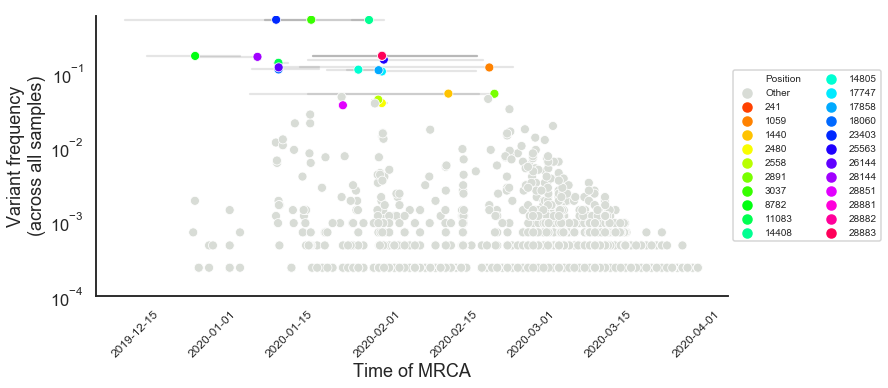

In [10]:
months = {2020 - 15/365: '2019-12-15',
          2020.0: '2020-01-01',
          2020 + 15/366: '2020-01-15',
          2020 + 32/366: '2020-02-01',
          2020 + 32/366 + 15/366: '2020-02-15',
          2020 + 32/366 + 30/366: '2020-03-01',
          2020 + 32/366 + 30/366 + 15/366: '2020-03-15',
          2020 + 32/366 + 30/366 + 32/366: '2020-04-01'}

rel = sns.relplot(x='time', y='vf',
            hue='Position', data=nt_time,
            hue_order=['Other'] + list(nt_time[nt_time['Position'] != 'Other'].index),
            palette=[sns.xkcd_rgb['light grey']] + list(sns.color_palette('hsv',
                                           len(nt_time[nt_time['Position'] != 'Other'].index))),
            height=5, aspect=2)
for x, vf in nt_time[nt_time['Position'] != 'Other'][['vf']].iterrows():
    plt.plot([nt_conf[x][0], nt_conf[x][1]],
             [vf, vf], '-', alpha=0.1, color='k', zorder=-1)
plt.xlabel('Time of MRCA')
plt.ylabel('Variant frequency\n(across all samples)')
plt.xticks(sorted(months),
           [months[x] for x in sorted(months)],
           rotation=45, ha='right', size=12)
rel._legend.remove()
plt.legend(fontsize=10,
           ncol=2, title='',
           loc='center left',
           bbox_to_anchor=(1, 0.5))
plt.ylim(0.999E-4, 0.6)
plt.yscale('log');

In [11]:
md(f'''_**Figure 3.** Early variants are more frequently observed.
Estimated age of each variant (N={napositions}) estimated through
[TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) is compared against
its observed frequency across all samples sequenced to date. The {nsites}
coupled sites are highlighted. MRCA, Most Recent Common Ancestor.
Horizontal lines indicate the confidence interval for the age
of each coupled variant._''')

_**Figure 3.** Early variants are more frequently observed.
Estimated age of each variant (N=2674) estimated through
[TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) is compared against
its observed frequency across all samples sequenced to date. The 22
coupled sites are highlighted. MRCA, Most Recent Common Ancestor.
Horizontal lines indicate the confidence interval for the age
of each coupled variant._

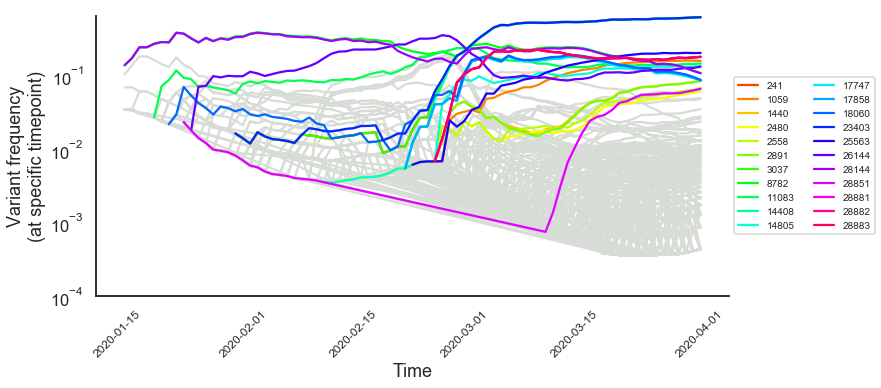

In [12]:
months = {2020 + 15/366: '2020-01-15',
          2020 + 32/366: '2020-02-01',
          2020 + 32/366 + 15/366: '2020-02-15',
          2020 + 32/366 + 30/366: '2020-03-01',
          2020 + 32/366 + 30/366 + 15/366: '2020-03-15',
          2020 + 32/366 + 30/366 + 32/366: '2020-04-01'}

lcolor = [sns.xkcd_rgb['light grey']] * len(ntt[np.invert(ntt['pos'].isin(cpos))]['pos'].unique())
lcolor += sns.color_palette('hsv', len(ntt[ntt['pos'].isin(cpos)]['pos'].unique()))
rel = sns.relplot(x='time',
            y='af',
            hue='pos',
            kind='line',
            data=ntt[ntt['af']!=0],
            palette=lcolor,
            hue_order=sorted(set(ntt['pos'].unique()).difference(cpos)) + sorted(cpos),
            height=5, aspect=2)
plt.xlabel('Time')
plt.ylabel('Variant frequency\n(at specific timepoint)')
plt.xticks(sorted(months),
           [months[x] for x in sorted(months)],
           rotation=45, ha='right', size=12)
handles, labels = rel.ax.get_legend_handles_labels()
by_label = {x: y for x, y in zip(labels, handles)
            if x != 'pos' and int(x) in cpos}
rel._legend.remove()
plt.legend(by_label.values(), by_label.keys(),
           fontsize=10,
           ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.999E-4, 0.65)
plt.yscale('log');

In [13]:
md(f'''_**Figure 4.** Empirical change in variant frequencies over time.
For each time point, only the samples from the previous 20 days are considered
to compute variant frequencies. The {nsites} coupled sites are highlighted._''')

_**Figure 4.** Empirical change in variant frequencies over time.
For each time point, only the samples from the previous 20 days are considered
to compute variant frequencies. The 22 coupled sites are highlighted._

In [14]:
md(f'''Discussion
---

The current push to scale up genomic sequencing is already delivering tens of viral genomes
released every day by a large network of laboratories across the world. Here, we focused
on understanding whether the genomic data collected to date could be used to find evidence of
co-evolution between sites along the genome. We have used a method based on Direct Coupling Analysis
([SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093))
to highlight {nsites} sites observed in {ngenomes} samples derived from [GISAID](https://platform.gisaid.org/epi3/frontend)
as of {today}, and pre-processed using the [nextstrain pipeline](https://academic.oup.com/bioinformatics/article/34/23/4121/5001388).
Based on this analysis, **we believe that the sites found to be strongly coupled by DCA
are in fact most likely false positives**, given the absence of convergence and the age
of mutations at those sites. We however acknowledge that methods that explicitly consider
the information about the age of each variant across the phylogeny might be able to overcome
these problems, as shown in [a study for influenza A surface proteins](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1001301).
Moreover, as the pandemics progresses in the months to come, we will revise this analysis with the hundreds of
new genome sequences that will likely be sequenced.''')

Discussion
---

The current push to scale up genomic sequencing is already delivering tens of viral genomes
released every day by a large network of laboratories across the world. Here, we focused
on understanding whether the genomic data collected to date could be used to find evidence of
co-evolution between sites along the genome. We have used a method based on Direct Coupling Analysis
([SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093))
to highlight 22 sites observed in 4189 samples derived from [GISAID](https://platform.gisaid.org/epi3/frontend)
as of 2020-04-07, and pre-processed using the [nextstrain pipeline](https://academic.oup.com/bioinformatics/article/34/23/4121/5001388).
Based on this analysis, **we believe that the sites found to be strongly coupled by DCA
are in fact most likely false positives**, given the absence of convergence and the age
of mutations at those sites. We however acknowledge that methods that explicitly consider
the information about the age of each variant across the phylogeny might be able to overcome
these problems, as shown in [a study for influenza A surface proteins](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1001301).
Moreover, as the pandemics progresses in the months to come, we will revise this analysis with the hundreds of
new genome sequences that will likely be sequenced.

In [15]:
md(f'''Methods
---

#### **Data preprocessing**

We downloaded {ngenomes} from GISAID on {today}, and used the
[nextstrain ncov pipeline](https://github.com/nextstrain/ncov) to filter and align them to the the reference
sequence from GenBank [MN908947](https://www.ncbi.nlm.nih.gov/nuccore/MN908947), using [mafft](https://academic.oup.com/mbe/article/30/4/772/1073398).
[IQ-tree](https://academic.oup.com/mbe/article/32/1/268/2925592) was
used to reconstruct the phylogeny, further refined by [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731).
Maximum likelihood ancestral reconstruction as implemented
in [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) was used to
infer the age of each observed variant.

#### **Direct Coupling Analysis**

We used the masked nucleotide sequence alignment as input for
[SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093)
using an allele frequency filter at 1% and sequencing reweighting threshold of 1.
Only pairs of sites estimated to
be strongly coupled (mutual information > 0.11) are retained for further analysis.

#### **Visualization**

The data was post-processed using the [Python programming language](https://www.python.org/) and
the jupyterlab environment, using the [numpy](https://aip.scitation.org/doi/abs/10.1109/MCSE.2011.37),
[scipy](https://www.nature.com/articles/s41592-019-0686-2), [biopython](https://academic.oup.com/bioinformatics/article/25/11/1422/330687),
[matplotlib](https://ieeexplore.ieee.org/document/4160265) and [seaborn](https://zenodo.org/record/3629446) libraries.

#### **Reproducibility**

The code used is available as a git repository on github (TBD), which
is an extension of the existing [nextstrain ncov pipeline](https://github.com/nextstrain/ncov).''')

Methods
---

#### **Data preprocessing**

We downloaded 4189 from GISAID on 2020-04-07, and used the
[nextstrain ncov pipeline](https://github.com/nextstrain/ncov) to filter and align them to the the reference
sequence from GenBank [MN908947](https://www.ncbi.nlm.nih.gov/nuccore/MN908947), using [mafft](https://academic.oup.com/mbe/article/30/4/772/1073398).
[IQ-tree](https://academic.oup.com/mbe/article/32/1/268/2925592) was
used to reconstruct the phylogeny, further refined by [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731).
Maximum likelihood ancestral reconstruction as implemented
in [TreeTime](https://academic.oup.com/ve/article/4/1/vex042/4794731) was used to
infer the age of each observed variant.

#### **Direct Coupling Analysis**

We used the masked nucleotide sequence alignment as input for
[SpydrPick](https://academic.oup.com/nar/article/47/18/e112/5541093)
using an allele frequency filter at 1% and sequencing reweighting threshold of 1.
Only pairs of sites estimated to
be strongly coupled (mutual information > 0.11) are retained for further analysis.

#### **Visualization**

The data was post-processed using the [Python programming language](https://www.python.org/) and
the jupyterlab environment, using the [numpy](https://aip.scitation.org/doi/abs/10.1109/MCSE.2011.37),
[scipy](https://www.nature.com/articles/s41592-019-0686-2), [biopython](https://academic.oup.com/bioinformatics/article/25/11/1422/330687),
[matplotlib](https://ieeexplore.ieee.org/document/4160265) and [seaborn](https://zenodo.org/record/3629446) libraries.

#### **Reproducibility**

The code used is available as a git repository on github (TBD), which
is an extension of the existing [nextstrain ncov pipeline](https://github.com/nextstrain/ncov).

In [16]:
md(f'''Acknowledgements
---

We are grateful to Dr. John Lees for providing feedback on implementations of DCA,
and to the [nextstrain team](https://nextstrain.org/) for providing the community with a robust and open analysis pipeline.
We are also grateful to all laboratories that submitted SARS-Cov-2 genomes to [GISAID](https://platform.gisaid.org/epi3/fronten),
specifically:

- AIDS Vaccine Research Laboratories
- ARGO Open Lab Platform for Genome sequencing
- African Centre of Excellence for Genomics of Infectious Diseases (ACEGID), Redeemer's University, Ede, Osun State, Nigeria
- Alaska State Public Health Virology Laboratory
- Andersen Lab, The Scripps Research Institute
- BCCDC Public Health Laboratory
- BGI & Institute of Microbiology, Chinese Academy of Sciences & Shandong First Medical University
- Beijing Genomics Institute (BGI)
- Beijing Institute of Microbiology and Epidemiology
- Bergthaler laboratory, CeMM Research Center for Molecular Medicine of the Austrian Academy of Sciences
- Bioinformatics Laboratory - LNCC
- Bioinformatics Research Group, Szentagothai Research Centre, University of Pecs
- Bundeswehr Institute of Microbiology
- CNR Virus des Infections Respiratoires - France SUD
- Center of Medical Microbiology, Virology, and Hospital Hygiene, University of Duesseldorf
- Centers for Disease Control, R.O.C. (Taiwan)
- Chan-Zuckerberg Biohub
- Charite Universitaetsmedizin Berlin, Institute of Virology
- Chiu Laboratory, University of California, San Francisco
- Chongqing Municipal Center for Disease Control and Prevention
- University of Melbourne at The Peter Doherty Institute for Infection and Immunity, and the Victorian Infectious Disease Reference Laboratory
- Dasman Diabetes Institute
- Department for Virology, Molecular Biology and Genome Research, R. G. Lugar Center for Public Health Research, National Center for Disease Control and Public Health (NCDC) of Georgia.
- Department of Clinical Diagnostics
- Department of Health Technology and Informatics, Faculty of Health and Social Science, The Hong Kong Polytechnic University
- Department of Healthcare Biotechnology
- Department of Infection, Immunity and Cardiovascular Disease, The Florey Institute, The Medical School, University of Sheffield
- Department of Laboratory Medicine, Lin-Kou Chang Gung Memorial Hospital, Taoyuan, Taiwan
- Department of Medical Microbiology, Faculty of Medicine, University of Malaya
- Department of Microbiology, Faculty of Medicine, Chinese University of Hong Kong, Hong Kong SAR, China
- Department of Microbiology, Guangdong Provincial Center for Diseases Control and Prevention
- Department of Microbiology, Institute for Viral Diseases, College of Medicine, Korea University
- Department of Microbiology, PathWest QEII Medical Centre
- Department of Microbiology, Zhejiang Provincial Center for Disease Control and Prevention
- Department of Pathology and Medicine, New York University School of Medicine
- Department of Virology, Faculty of Medicine, University of Helsinki, Helsinki, Finland
- Department of microbiology laboratory, Anhui Provincial Center for Disease Control and Prevention
- Departments of Pathology and Medicine, New York University School of Medicine
- Division of Viral Diseases, Center for Laboratory Control of Infectious Diseases, Korea Centers for Diseases Control and Prevention
- Division of Viral Diseases, Centers for Disease Control and Prevention
- Erasmus Medical Center
- Fujian Center for Disease Control and Prevention
- GIGA Medical Genomics
- Geelong Centre for Emerging Infectious Diseases
- Gorgas Memorial Institute for Health Studies
- Grubaugh Lab - Yale School of Public Health
- Guangdong Provincial Center for Disease Control and Prevention
- Guangdong Provincial Institution of Public Health
- Hangzhou Center for Disease and Control Microbiology Lab
- Hong Kong Department of Health
- Hopitaux universitaires de Geneve Laboratoire de Virologie
- Hospital Universitari Vall d'Hebron (HUVH) - Vall d'Hebron Research Institute (VHIR)
- Hospital Universitario La Paz
- Hubei Provincial Center for Disease Control and Prevention
- INMI Lazzaro Spallanzani IRCCS
- Indian Council of Medical Research-National Institute of Virology, Microbial Containment Complex
- Infectious Disease Control Center
- Infectious Disease Research Department, King Abdullah International Medical Research Center (KAIMRC)
- Inspection Center of Hanghzou Center for Disease Control and Prevention
- Institut Pasteur de Dakar
- Institute information KU Leuven, Clinical and Epidemiological Virology
- Institute of Environmental Science and Research (ESR)
- Institute of Medical Virology, University of Zurich
- Institute of Microbiology and Immunology, Faculty of Medicine, University of Ljubljana
- Institute of Microbiology, Universidad San Francisco de Quito
- Institute of Pathogen Biology, Chinese Academy of Medical Sciences & Peking Union Medical College
- Institute of Viral Disease Control and Prevention, China CDC
- Institute of Virology, Biomedical Research Center of the Slovak Academy of Sciences, Bratislava; Comenius University Science Park, Bratislava
- Instituto Adolfo Lutz, Interdisciplinary Procedures Center, Strategic Laboratory
- Instituto Gulbenkian de Ciencia
- Instituto Nacional Enfermedades Infecciosas C.G.Malbran
- Instituto Nacional de Salud, Universidad Cooperativa de Colombia, Instituto Alexander von Humboldt, Imperial College-London, London School of Hygiene & Tropical Medicine
- Instituto Nacional de Saude (INSA)
- Instituto Oswaldo Cruz FIOCRUZ - Laboratory of Respiratory Viruses and Measles (LVRS)
- Instituto de Diagnostico y Referencia Epidemiologicos (INDRE)
- Instituto de Salud Carlos III
- Instituto de Salud Publica de Chile
- IrsiCaixa AIDS Research Lab
- Israel Institute for Biological Research
- Istituto Zooprofilattico Sperimentale dell'Abruzzo e del Molise "G.Caporale"
- Jiangsu Provincial Center for Disease Control & Prevention
- Jiangxi province Center for Disease Control and Prevention
- KU Leuven, Clinical and Epidemiological Virology
- Kabara Cancer Research Institute
- Key Laboratory of Human Diseases, Comparative Medicine, Institute of Laboratory Animal Science
- Key Laboratory of Medical Molecular Virology (MOE-NHC-CAMS)
- Korea Centers for Disease Control & Prevention (KCDC) Center for Laboratory Control of Infectious Diseases Division of Viral Diseases
- Laboratoire National de Sante, Microbiology, Epidemiology and Microbial Genomics
- Laboratoire Nationale de Sante, Microbiology, Epidemiology and Microbial Genomics
- Laboratoire Virpath, CIRI U111, UCBL1, INSERM, CNRS, ENS Lyon
- Laboratorio de Ecologia de Doencas Transmissiveis na Amazonia, Instituto Leonidas e Maria Deane - Fiocruz Amazonia
- Laboratorio de Referencia Nacional de Biotecnologia y Biologia Molecular. Instituto Nacional de Salud Peru
- Laboratorio di Microbiologia e Virologia, Universita Vita-Salute San Raffaele, Milano
- Laboratory for Functional Genome Analysis, Dept. Genomics, Gene Center of the LMU Munich
- Laboratory of Biology, Department of Medicine, Democritus University of Thrace, Greece
- Laboratory of Infectious Diseases, Department of Biomedical and Clinical Sciences L. Sacco, University of Milan
- Laboratory of Virology, INMI Lazzaro Spallanzani IRCCS
- Li Ka Shing Faculty of Medicine, The University of Hong Kong
- MRC-University of Glasgow Centre for Virus Research
- MSHS Pathogen Surveillance Program
- Malaysia Genome Institute
- Microbial Genomics Core Lab, National Taiwan University Centers of Genomic and Precision Medicine
- Microbiological Diagnostic Unit Public Health Laboratory
- Microbiology and Immunology department
- Ministry of Health Turkey
- Minnesota Department of Health, Public Health Laboratory
- Molecular Biology and Biotechnology Lab II
- NSW Health Pathology - Institute of Clinical Pathology and Medical Research; Westmead Hospital; University of Sydney
- National Centre for Infectious Diseases, National Centre for Infectious Diseases
- National Influenza Center - National Institute of Hygiene and Epidemiology (NIHE)
- National Influenza Center, Indian Council of Medical Research - National Institute of Virology
- National Influenza Center, National Institute of Hygiene and Epidemiology (NIHE)
- National Institute for Communicable Disease Control and Prevention (ICDC) Chinese Center for Disease Control and Prevention (China CDC)
- National Institute for Communicable Diseases of the National Health Laboratory Service
- National Institute for Viral Disease Control and Prevention, China CDC
- National Microbiology Laboratory
- National Public Health Laboratory
- National Public Health Laboratory, National Centre for Infectious Diseases
- National Reference Center for Viruses of Respiratory Infections, Institut Pasteur, Paris
- National Research Center for Translational Medicine (Shanghai), Ruijin Hospital affiliated to Shanghai Jiao Tong University School of Medicine & Shanghai Public Health Clinical Center
- Norwegian Institute of Public Health, Department of Virology
- Onderzoeksgroep Virologie
- Ontario Agency for Health Protection and Promotion (OAHPP)
- PathWest Laboratory Medicine WA
- Pathogen Discovery, Respiratory Viruses Branch, Division of Viral Diseases, Centers for Disease Control and Prevention
- Pathogen Genomics Center, National Institute of Infectious Diseases
- Pathogen Sequencing Lab, National Institute for Biomedical Research (INRB)
- Programme in Emerging Infectious Diseases, Duke-NUS Medical School
- Public Health Laboratory, Saudi CDC
- Public Health Ontario Laboratories
- Public Health Virology Laboratory
- Public Health Wales Microbiology Cardiff
- R. G. Lugar Center for Public Health Research, National Center for Disease Control and Public Health (NCDC) of Georgia.
- Respiratory Virus Unit, Microbiology Services Colindale, Public Health England
- Ryota Kumagai Tokyo Metropolitan Institute of Public Health
- SCSFRI, South China Sea Fisheries Research Institute, Chinese Academy of Fishery Sciences (SCSFRI, CAFS)
- Saitama Medical University
- School of Public Health, The University of Hon g Kong
- School of Public Health, The University of Hong Kong
- Seattle Flu Study
- Second Hospital of Anhui Medical University
- Sequencing and Bioinformatics Service and Molecular Epidemiology Research Group. FISABIO-Public Health
- Shenzhen Key Laboratory of Pathogen and Immunity, National Clinical Research Center for Infectious Disease, Shenzhen Third People's Hospital
- South China Agricultural University
- State Key Laboratory for Diagnosis and Treatment of Infectious Diseases, National Clinical Research Center for Infectious Diseases, First Affiliated Hospital, Zhejiang University School of Medicine, Hangzhou, China
- State Key Laboratory of Virology, Wuhan University
- State Veterinary Institute Prague
- Statens Serum Institute
- Swiss National Reference Centre for Influenza
- Taiwan Centers for Disease Control
- Takayuki Hishiki Kanagawa Prefectural Institute of Public Health, Department of Microbiology
- Technology Centre, Guangzhou Customs
- The First Affiliated Hospital of Guangzhou Medical University & BGI-Shenzhen
- The University of Hong Kong
- UCD National Virus Reference Laboratory
- UW Virology Lab
- Unit for Laboratory Development and Technology Transfer, Public Health Agency of Sweden
- University Hospital Basel, Clinical Bacteriology
- University Hospital Basel, Clinical Virology
- University Hospital Basel, Labormedizin
- University of California, San Francisco
- University of Otago
- University of Washington Virology Lab
- University of Wisconsin - Madison AIDS Vaccine Research Laboratories
- Utah Public Health Laboratory
- VA DCLS
- ViFU
- Victorian Infectious Diseases Reference Laboratory and Microbiological Diagnostic Unit Public Health Laboratory, Doherty Institute
- Virginia Division of Consolidated Laboratories
- ViroGenetics - BSL3 Laboratory of Virology; Human Genome Variation Research Group & Genomics Centre MCB; Bioinformatics Research Group Department of Virology
- Virology Department, Royal Infirmary of Edinburgh, NHS Lothian
- Virology Laboratory, Scientific Department, Army Medical Center
- Virology Unit, Institut Pasteur du Cambodge
- Virology and Legal Medicine Laboratories, Department of Biomedical Sciences and Public Health, University Politecnica delle Marche
- WHO National Influenza Centre Russian Federation
- Weifang Center for Disease Control and Prevention & BGI-Shenzhen
- Wuhan Institute of Virology, Chinese Academy of Sciences
- deCODE genetics
- the First Affiliated Hospital of Guangzhou Medical University & BGI-Shenzhen
- Department of Medical Sciences, Ministry of Public Health, Thailand
- Thai Red Cross Emerging Infectious Diseases - Health Science Centre
- Department of Disease Control, Ministry of Public Health, Thailand
- Shandong Academy of Medical Sciences
- General Hospital of Central Theater Command of People's Liberation Army of China
- Imperial College-London London School of Hygiene & Tropical Medicine''')

Acknowledgements
---

We are grateful to Dr. John Lees for providing feedback on implementations of DCA,
and to the [nextstrain team](https://nextstrain.org/) for providing the community with a robust and open analysis pipeline.
We are also grateful to all laboratories that submitted SARS-Cov-2 genomes to [GISAID](https://platform.gisaid.org/epi3/fronten),
specifically:

- AIDS Vaccine Research Laboratories
- ARGO Open Lab Platform for Genome sequencing
- African Centre of Excellence for Genomics of Infectious Diseases (ACEGID), Redeemer's University, Ede, Osun State, Nigeria
- Alaska State Public Health Virology Laboratory
- Andersen Lab, The Scripps Research Institute
- BCCDC Public Health Laboratory
- BGI & Institute of Microbiology, Chinese Academy of Sciences & Shandong First Medical University
- Beijing Genomics Institute (BGI)
- Beijing Institute of Microbiology and Epidemiology
- Bergthaler laboratory, CeMM Research Center for Molecular Medicine of the Austrian Academy of Sciences
- Bioinformatics Laboratory - LNCC
- Bioinformatics Research Group, Szentagothai Research Centre, University of Pecs
- Bundeswehr Institute of Microbiology
- CNR Virus des Infections Respiratoires - France SUD
- Center of Medical Microbiology, Virology, and Hospital Hygiene, University of Duesseldorf
- Centers for Disease Control, R.O.C. (Taiwan)
- Chan-Zuckerberg Biohub
- Charite Universitaetsmedizin Berlin, Institute of Virology
- Chiu Laboratory, University of California, San Francisco
- Chongqing Municipal Center for Disease Control and Prevention
- University of Melbourne at The Peter Doherty Institute for Infection and Immunity, and the Victorian Infectious Disease Reference Laboratory
- Dasman Diabetes Institute
- Department for Virology, Molecular Biology and Genome Research, R. G. Lugar Center for Public Health Research, National Center for Disease Control and Public Health (NCDC) of Georgia.
- Department of Clinical Diagnostics
- Department of Health Technology and Informatics, Faculty of Health and Social Science, The Hong Kong Polytechnic University
- Department of Healthcare Biotechnology
- Department of Infection, Immunity and Cardiovascular Disease, The Florey Institute, The Medical School, University of Sheffield
- Department of Laboratory Medicine, Lin-Kou Chang Gung Memorial Hospital, Taoyuan, Taiwan
- Department of Medical Microbiology, Faculty of Medicine, University of Malaya
- Department of Microbiology, Faculty of Medicine, Chinese University of Hong Kong, Hong Kong SAR, China
- Department of Microbiology, Guangdong Provincial Center for Diseases Control and Prevention
- Department of Microbiology, Institute for Viral Diseases, College of Medicine, Korea University
- Department of Microbiology, PathWest QEII Medical Centre
- Department of Microbiology, Zhejiang Provincial Center for Disease Control and Prevention
- Department of Pathology and Medicine, New York University School of Medicine
- Department of Virology, Faculty of Medicine, University of Helsinki, Helsinki, Finland
- Department of microbiology laboratory, Anhui Provincial Center for Disease Control and Prevention
- Departments of Pathology and Medicine, New York University School of Medicine
- Division of Viral Diseases, Center for Laboratory Control of Infectious Diseases, Korea Centers for Diseases Control and Prevention
- Division of Viral Diseases, Centers for Disease Control and Prevention
- Erasmus Medical Center
- Fujian Center for Disease Control and Prevention
- GIGA Medical Genomics
- Geelong Centre for Emerging Infectious Diseases
- Gorgas Memorial Institute for Health Studies
- Grubaugh Lab - Yale School of Public Health
- Guangdong Provincial Center for Disease Control and Prevention
- Guangdong Provincial Institution of Public Health
- Hangzhou Center for Disease and Control Microbiology Lab
- Hong Kong Department of Health
- Hopitaux universitaires de Geneve Laboratoire de Virologie
- Hospital Universitari Vall d'Hebron (HUVH) - Vall d'Hebron Research Institute (VHIR)
- Hospital Universitario La Paz
- Hubei Provincial Center for Disease Control and Prevention
- INMI Lazzaro Spallanzani IRCCS
- Indian Council of Medical Research-National Institute of Virology, Microbial Containment Complex
- Infectious Disease Control Center
- Infectious Disease Research Department, King Abdullah International Medical Research Center (KAIMRC)
- Inspection Center of Hanghzou Center for Disease Control and Prevention
- Institut Pasteur de Dakar
- Institute information KU Leuven, Clinical and Epidemiological Virology
- Institute of Environmental Science and Research (ESR)
- Institute of Medical Virology, University of Zurich
- Institute of Microbiology and Immunology, Faculty of Medicine, University of Ljubljana
- Institute of Microbiology, Universidad San Francisco de Quito
- Institute of Pathogen Biology, Chinese Academy of Medical Sciences & Peking Union Medical College
- Institute of Viral Disease Control and Prevention, China CDC
- Institute of Virology, Biomedical Research Center of the Slovak Academy of Sciences, Bratislava; Comenius University Science Park, Bratislava
- Instituto Adolfo Lutz, Interdisciplinary Procedures Center, Strategic Laboratory
- Instituto Gulbenkian de Ciencia
- Instituto Nacional Enfermedades Infecciosas C.G.Malbran
- Instituto Nacional de Salud, Universidad Cooperativa de Colombia, Instituto Alexander von Humboldt, Imperial College-London, London School of Hygiene & Tropical Medicine
- Instituto Nacional de Saude (INSA)
- Instituto Oswaldo Cruz FIOCRUZ - Laboratory of Respiratory Viruses and Measles (LVRS)
- Instituto de Diagnostico y Referencia Epidemiologicos (INDRE)
- Instituto de Salud Carlos III
- Instituto de Salud Publica de Chile
- IrsiCaixa AIDS Research Lab
- Israel Institute for Biological Research
- Istituto Zooprofilattico Sperimentale dell'Abruzzo e del Molise "G.Caporale"
- Jiangsu Provincial Center for Disease Control & Prevention
- Jiangxi province Center for Disease Control and Prevention
- KU Leuven, Clinical and Epidemiological Virology
- Kabara Cancer Research Institute
- Key Laboratory of Human Diseases, Comparative Medicine, Institute of Laboratory Animal Science
- Key Laboratory of Medical Molecular Virology (MOE-NHC-CAMS)
- Korea Centers for Disease Control & Prevention (KCDC) Center for Laboratory Control of Infectious Diseases Division of Viral Diseases
- Laboratoire National de Sante, Microbiology, Epidemiology and Microbial Genomics
- Laboratoire Nationale de Sante, Microbiology, Epidemiology and Microbial Genomics
- Laboratoire Virpath, CIRI U111, UCBL1, INSERM, CNRS, ENS Lyon
- Laboratorio de Ecologia de Doencas Transmissiveis na Amazonia, Instituto Leonidas e Maria Deane - Fiocruz Amazonia
- Laboratorio de Referencia Nacional de Biotecnologia y Biologia Molecular. Instituto Nacional de Salud Peru
- Laboratorio di Microbiologia e Virologia, Universita Vita-Salute San Raffaele, Milano
- Laboratory for Functional Genome Analysis, Dept. Genomics, Gene Center of the LMU Munich
- Laboratory of Biology, Department of Medicine, Democritus University of Thrace, Greece
- Laboratory of Infectious Diseases, Department of Biomedical and Clinical Sciences L. Sacco, University of Milan
- Laboratory of Virology, INMI Lazzaro Spallanzani IRCCS
- Li Ka Shing Faculty of Medicine, The University of Hong Kong
- MRC-University of Glasgow Centre for Virus Research
- MSHS Pathogen Surveillance Program
- Malaysia Genome Institute
- Microbial Genomics Core Lab, National Taiwan University Centers of Genomic and Precision Medicine
- Microbiological Diagnostic Unit Public Health Laboratory
- Microbiology and Immunology department
- Ministry of Health Turkey
- Minnesota Department of Health, Public Health Laboratory
- Molecular Biology and Biotechnology Lab II
- NSW Health Pathology - Institute of Clinical Pathology and Medical Research; Westmead Hospital; University of Sydney
- National Centre for Infectious Diseases, National Centre for Infectious Diseases
- National Influenza Center - National Institute of Hygiene and Epidemiology (NIHE)
- National Influenza Center, Indian Council of Medical Research - National Institute of Virology
- National Influenza Center, National Institute of Hygiene and Epidemiology (NIHE)
- National Institute for Communicable Disease Control and Prevention (ICDC) Chinese Center for Disease Control and Prevention (China CDC)
- National Institute for Communicable Diseases of the National Health Laboratory Service
- National Institute for Viral Disease Control and Prevention, China CDC
- National Microbiology Laboratory
- National Public Health Laboratory
- National Public Health Laboratory, National Centre for Infectious Diseases
- National Reference Center for Viruses of Respiratory Infections, Institut Pasteur, Paris
- National Research Center for Translational Medicine (Shanghai), Ruijin Hospital affiliated to Shanghai Jiao Tong University School of Medicine & Shanghai Public Health Clinical Center
- Norwegian Institute of Public Health, Department of Virology
- Onderzoeksgroep Virologie
- Ontario Agency for Health Protection and Promotion (OAHPP)
- PathWest Laboratory Medicine WA
- Pathogen Discovery, Respiratory Viruses Branch, Division of Viral Diseases, Centers for Disease Control and Prevention
- Pathogen Genomics Center, National Institute of Infectious Diseases
- Pathogen Sequencing Lab, National Institute for Biomedical Research (INRB)
- Programme in Emerging Infectious Diseases, Duke-NUS Medical School
- Public Health Laboratory, Saudi CDC
- Public Health Ontario Laboratories
- Public Health Virology Laboratory
- Public Health Wales Microbiology Cardiff
- R. G. Lugar Center for Public Health Research, National Center for Disease Control and Public Health (NCDC) of Georgia.
- Respiratory Virus Unit, Microbiology Services Colindale, Public Health England
- Ryota Kumagai Tokyo Metropolitan Institute of Public Health
- SCSFRI, South China Sea Fisheries Research Institute, Chinese Academy of Fishery Sciences (SCSFRI, CAFS)
- Saitama Medical University
- School of Public Health, The University of Hon g Kong
- School of Public Health, The University of Hong Kong
- Seattle Flu Study
- Second Hospital of Anhui Medical University
- Sequencing and Bioinformatics Service and Molecular Epidemiology Research Group. FISABIO-Public Health
- Shenzhen Key Laboratory of Pathogen and Immunity, National Clinical Research Center for Infectious Disease, Shenzhen Third People's Hospital
- South China Agricultural University
- State Key Laboratory for Diagnosis and Treatment of Infectious Diseases, National Clinical Research Center for Infectious Diseases, First Affiliated Hospital, Zhejiang University School of Medicine, Hangzhou, China
- State Key Laboratory of Virology, Wuhan University
- State Veterinary Institute Prague
- Statens Serum Institute
- Swiss National Reference Centre for Influenza
- Taiwan Centers for Disease Control
- Takayuki Hishiki Kanagawa Prefectural Institute of Public Health, Department of Microbiology
- Technology Centre, Guangzhou Customs
- The First Affiliated Hospital of Guangzhou Medical University & BGI-Shenzhen
- The University of Hong Kong
- UCD National Virus Reference Laboratory
- UW Virology Lab
- Unit for Laboratory Development and Technology Transfer, Public Health Agency of Sweden
- University Hospital Basel, Clinical Bacteriology
- University Hospital Basel, Clinical Virology
- University Hospital Basel, Labormedizin
- University of California, San Francisco
- University of Otago
- University of Washington Virology Lab
- University of Wisconsin - Madison AIDS Vaccine Research Laboratories
- Utah Public Health Laboratory
- VA DCLS
- ViFU
- Victorian Infectious Diseases Reference Laboratory and Microbiological Diagnostic Unit Public Health Laboratory, Doherty Institute
- Virginia Division of Consolidated Laboratories
- ViroGenetics - BSL3 Laboratory of Virology; Human Genome Variation Research Group & Genomics Centre MCB; Bioinformatics Research Group Department of Virology
- Virology Department, Royal Infirmary of Edinburgh, NHS Lothian
- Virology Laboratory, Scientific Department, Army Medical Center
- Virology Unit, Institut Pasteur du Cambodge
- Virology and Legal Medicine Laboratories, Department of Biomedical Sciences and Public Health, University Politecnica delle Marche
- WHO National Influenza Centre Russian Federation
- Weifang Center for Disease Control and Prevention & BGI-Shenzhen
- Wuhan Institute of Virology, Chinese Academy of Sciences
- deCODE genetics
- the First Affiliated Hospital of Guangzhou Medical University & BGI-Shenzhen
- Department of Medical Sciences, Ministry of Public Health, Thailand
- Thai Red Cross Emerging Infectious Diseases - Health Science Centre
- Department of Disease Control, Ministry of Public Health, Thailand
- Shandong Academy of Medical Sciences
- General Hospital of Central Theater Command of People's Liberation Army of China
- Imperial College-London London School of Hygiene & Tropical Medicine

In [17]:
# ack = pd.read_csv('data/metadata.tsv', sep='\t')

# for i in sorted({x.replace('  ', ' ').replace('/', '-') for x in ack[['submitting_lab']].values.flatten()}):
#     print('- ' + i)